In [1]:
!pip install tf_keras_vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from matplotlib import cm

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input


from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam


# Load Model

In [3]:
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# upload Golden_Retriever.jpg
!gdown 14fFpJlD2c35aXHw11XG9ODjeL9MREVit

# upload Border_Collie.jpg
!gdown 1oJ23CMIQO5iBP_ipOpB68fi6uYbuqeYU

# upload White_Wolf.jpg
!gdown 1W8uO2_ROhwSscAO-4Si_7LfyU7le_jnX

Downloading...
From: https://drive.google.com/uc?id=14fFpJlD2c35aXHw11XG9ODjeL9MREVit
To: /content/Golden_Retriever.jpg
100% 84.4k/84.4k [00:00<00:00, 75.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oJ23CMIQO5iBP_ipOpB68fi6uYbuqeYU
To: /content/Border_Collie.jpg
100% 78.3k/78.3k [00:00<00:00, 61.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W8uO2_ROhwSscAO-4Si_7LfyU7le_jnX
To: /content/White_Wolf.jpg
100% 42.3k/42.3k [00:00<00:00, 17.7MB/s]


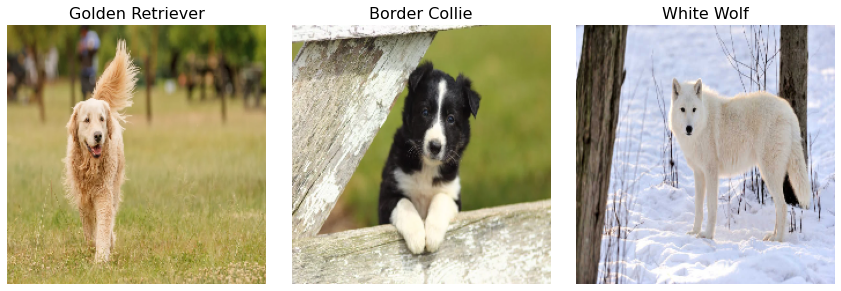

In [5]:
# Load images
img1 = cv2.imread('Golden_Retriever.jpg')
img2 = cv2.imread('Border_Collie.jpg')
img3 = cv2.imread('White_Wolf.jpg')

image_titles = ['Golden Retriever', 'Border Collie', 'White Wolf']
images = np.asarray([img1, img2, img3], dtype='object')
for i, img in enumerate(images):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images[i] = cv2.resize(img, (224, 224))

# Preparing input data for VGG16
X = [np.expand_dims(img, axis=0) for img in images]
X = np.concatenate(X, axis=0).astype(np.float32)

# Plot images
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
  ax[i].set_title(title, fontsize=16)
  ax[i].imshow(images[i])
  ax[i].axis('off')
plt.tight_layout()
plt.show()

# Model modifier, Score function and Render

當 softmax 用於模型的最後一層時，可能會阻礙注意力圖像的生成，因此需替換成線性激活函數。

然後，**必須** 定義 score 函式返回目標分數的分數函數 (對應類別的得分值)。

- [IMAGENET 1000 Class List](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)

In [6]:
def model_modifier_function(cloned_model):
  cloned_model.layers[-1].activation = tf.keras.activations.linear

In [7]:
def score_function(output):
  # The `output` variable refers to the output of the model,
  # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
  return (output[1][207], output[2][232], output[0][270], )

In [8]:
def images_plot(image_titles, images_array, visualize_cam):
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
  for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(visualize_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
  plt.tight_layout()
  plt.show()

# GradCAM

GradCAM 是一種將輸入注意力可視化的方法。 它不使用模型輸出的梯度，而是使用倒數第二層的輸出（dense layer 之前的 convolution layer）。

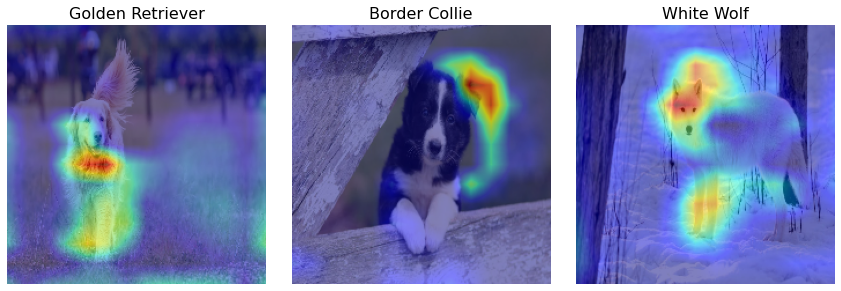

In [9]:
# Create Gradcam object
gradcam = Gradcam(model, model_modifier=model_modifier_function, clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score_function, X, penultimate_layer=-1)

# Plot results
images_plot(image_titles, images, visualize_cam=cam)


如結果所示，GradCAM 可以直觀地了解模型的注意力在哪裡，但是會發現，可視化的注意力並沒有完全覆蓋圖片中的類別物件。

# GradCAM++

GradCAM++ 可以為 CNN 模型預測提供更好的視覺解釋。

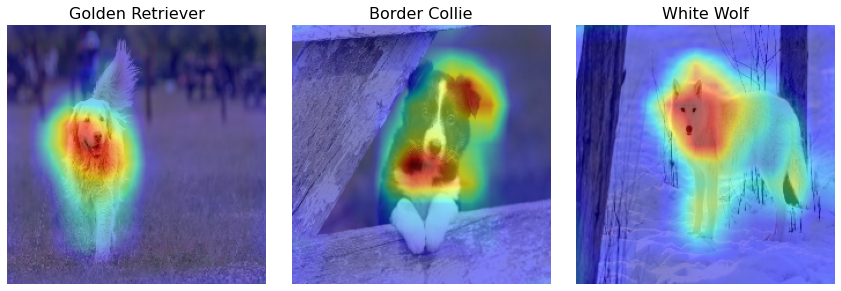

In [10]:
# Create GradCAM++ object
gradcam = GradcamPlusPlus(model, model_modifier=model_modifier_function, clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score_function, X, penultimate_layer=-1)

# Plot results
images_plot(image_titles, images, cam)


# ScoreCAM

ScoreCAM 是另一種生成 Class Activation Map 的方法。 該方法的特點是不同於 GradCAM 和 GradCAM，他使用無梯度方法進行。

48/48 [==============================] - 8s 103ms/step


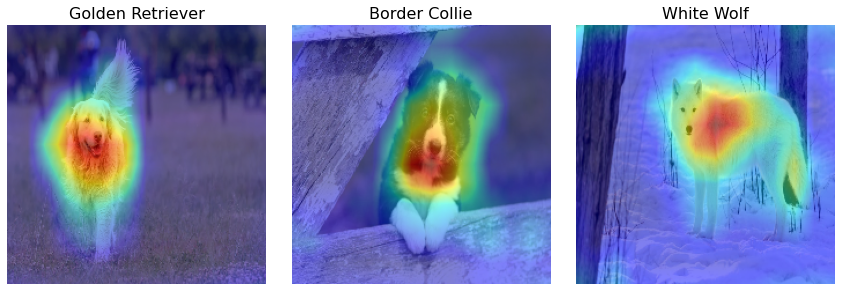

In [11]:
# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score_function, X, penultimate_layer=-1)

# Plot results
images_plot(image_titles, images, cam)

# Faster-ScoreCAM

ScoreCAM 比其他方法需要更多的時間來處理。  
比 ScoreCAM 更快速的 Faster-ScorecAM 由 @tabayashi0117 設計。

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam

Faster-Score-CAM 在 Score-CAM 中增加了“只使用方差較大的 channel 作為 mask 圖像”的處理。 （max_N = -1 是原始的 Score-CAM）。

3/3 [==============================] - 2s 1s/step


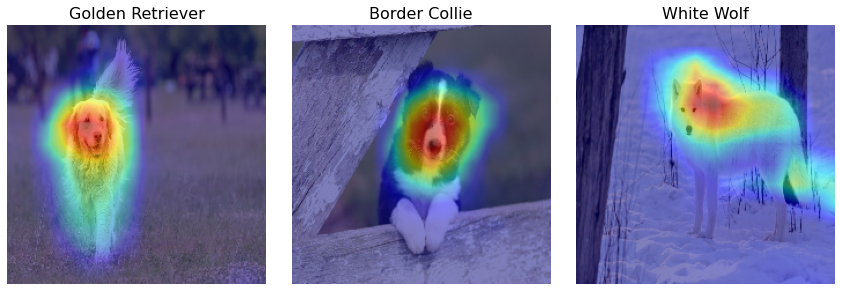

In [12]:
# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=model_modifier_function)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score_function, X, penultimate_layer=-1, max_N=10)

# Plot results
images_plot(image_titles, images, cam)

參考資源
- [reference](https://github.com/keisen/tf-keras-vis)